In [290]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [291]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [292]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [293]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [294]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*(random.random()+1), -0.1*random.random()]  # vertical state
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0).sum(dim=0)
        return states

In [295]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        conv_log = []
        conv_itr = []
        for epoch in range(epochs):
            loss = self.step()
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            cord = self.visualize()
        print('Landing Trajectory:')
        for r in range(N):
            plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
            plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4])
        plt.show()
        return data

[[ 0.8488033   0.08930507 -0.31382352 -0.04317746  0.64202765 -0.03683823]
 [ 1.43440668 -0.10355314  0.37170965  0.04359249  0.69917537 -0.03309961]
 [ 1.06927431 -0.1004238  -0.0301261  -0.02382285  0.53433092 -0.09838092]
 [ 1.25586076 -0.10380711 -0.03284897 -0.01999713  0.64038919 -0.01129038]
 [-0.83959109 -0.02329861 -0.42810848 -0.03360795  0.63110596 -0.08885405]]
[1] loss: 77.625


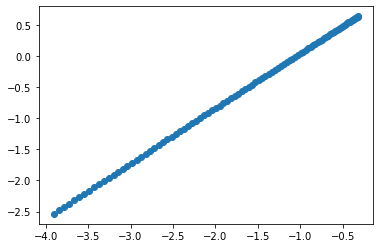

[2] loss: 41.707


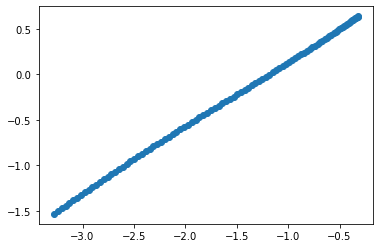

[3] loss: 20.927


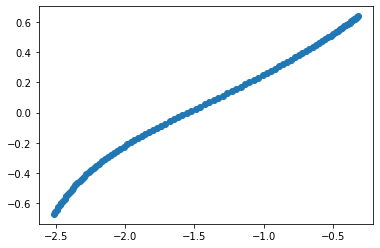

[4] loss: 12.649


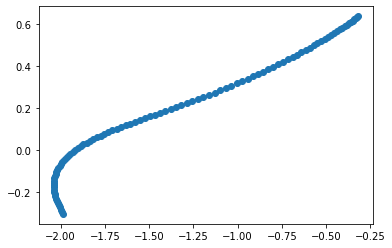

[5] loss: 7.458


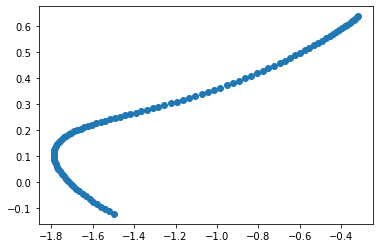

[6] loss: 4.552


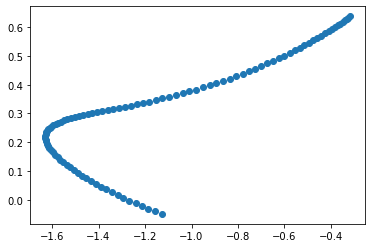

[7] loss: 3.002


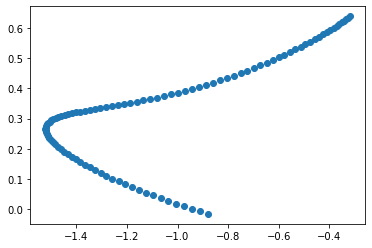

[8] loss: 2.066


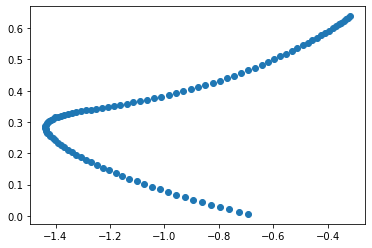

[9] loss: 1.414


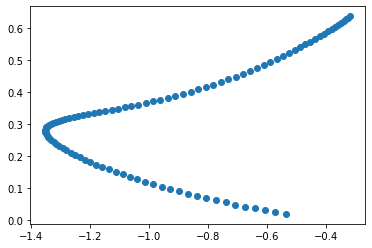

[10] loss: 1.025


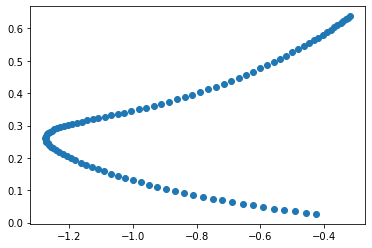

[11] loss: 0.810


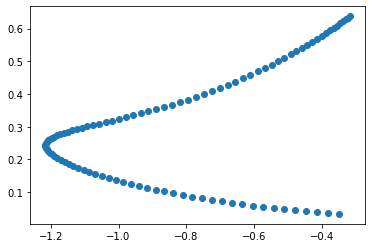

[12] loss: 0.676


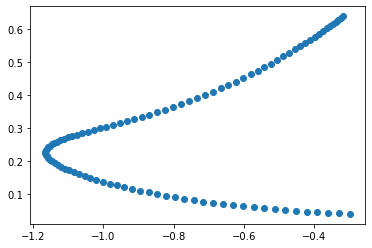

[13] loss: 0.574


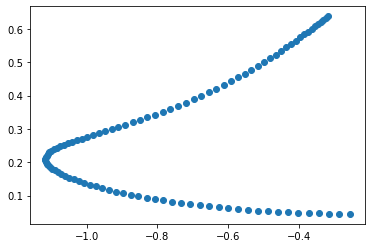

[14] loss: 0.485


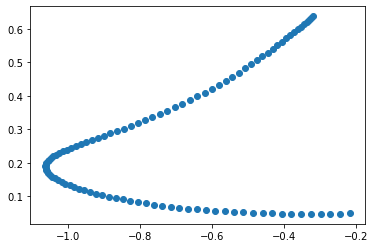

[15] loss: 0.405


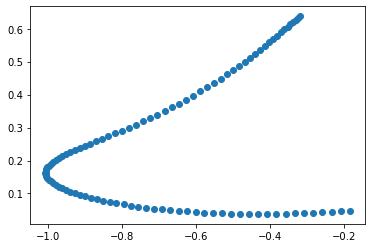

[16] loss: 0.341


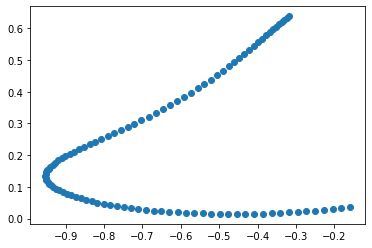

[17] loss: 0.294


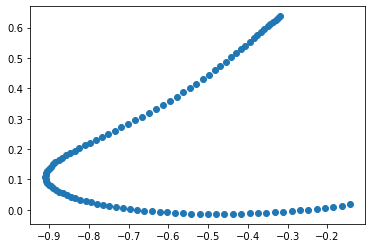

[18] loss: 0.254


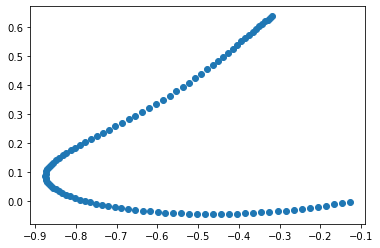

[19] loss: 0.196


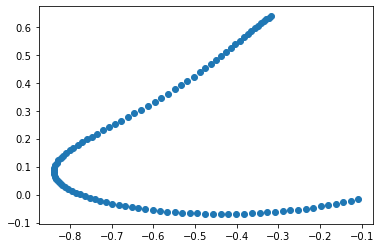

[20] loss: 0.150


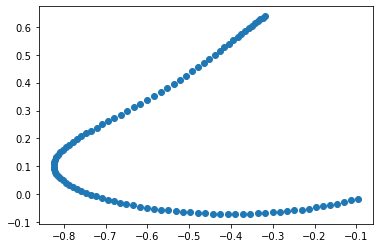

[21] loss: 0.125


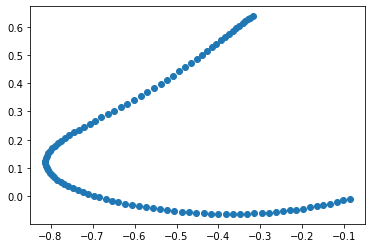

[22] loss: 0.105


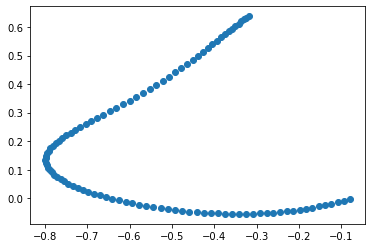

[23] loss: 0.089


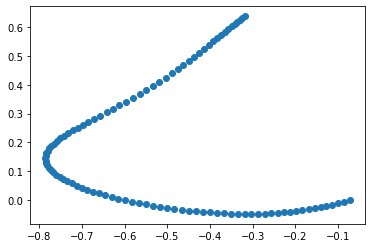

[24] loss: 0.077


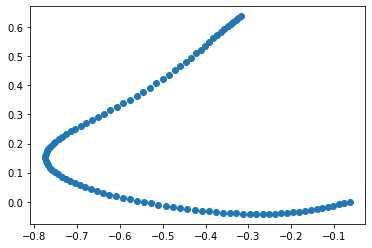

[25] loss: 0.065


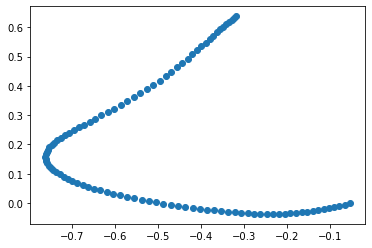

[26] loss: 0.056


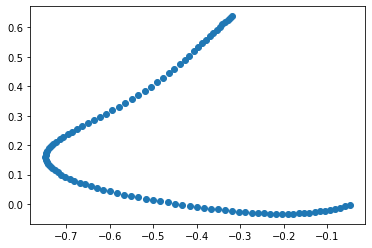

[27] loss: 0.048


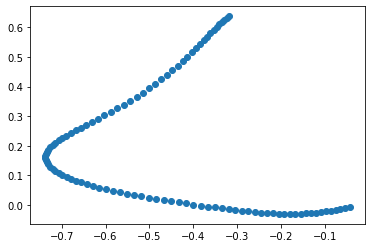

[28] loss: 0.043


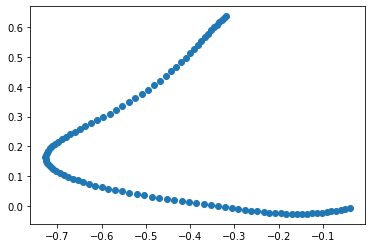

[29] loss: 0.038


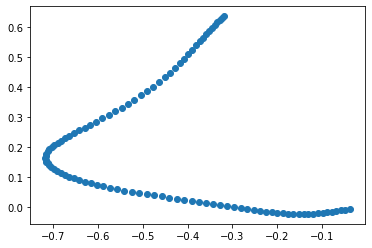

[30] loss: 0.034


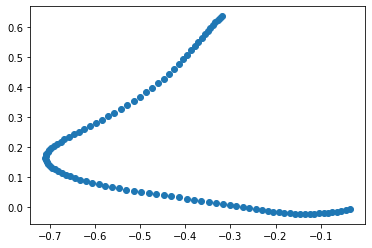

[31] loss: 0.031


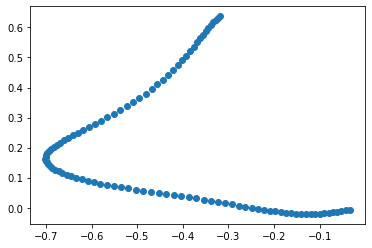

[32] loss: 0.028


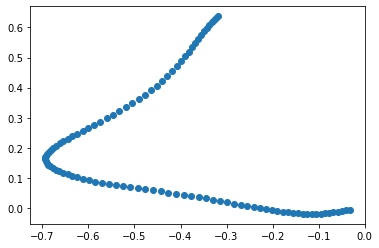

[33] loss: 0.026


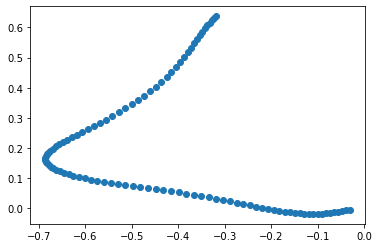

[34] loss: 0.023


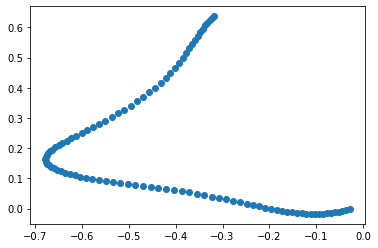

[35] loss: 0.019


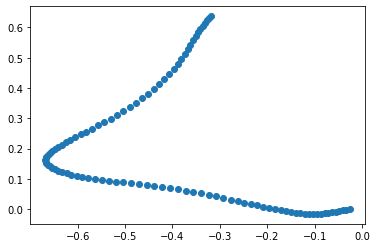

[36] loss: 0.016


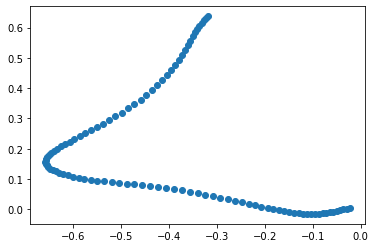

[37] loss: 0.014


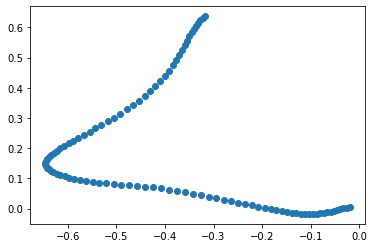

[38] loss: 0.012


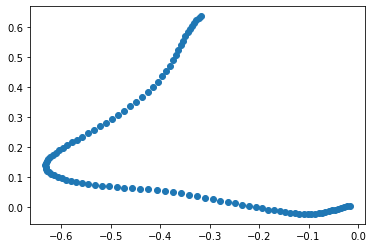

[39] loss: 0.009


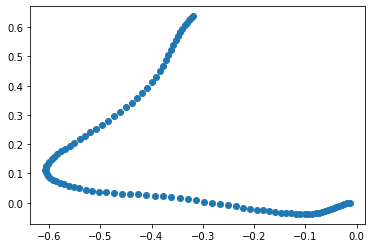

[40] loss: 0.007


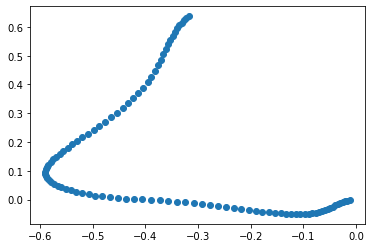

[41] loss: 0.005


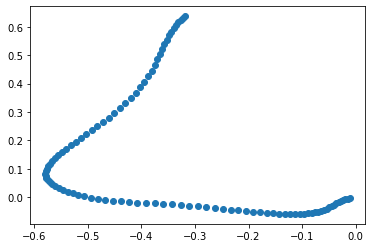

[42] loss: 0.004


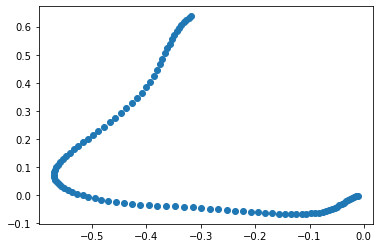

[43] loss: 0.004


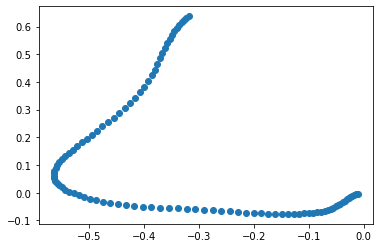

[44] loss: 0.003


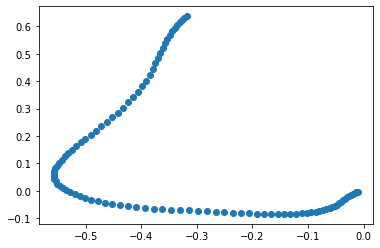

[45] loss: 0.003


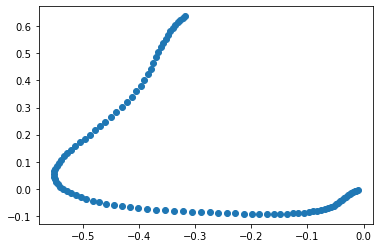

[46] loss: 0.003


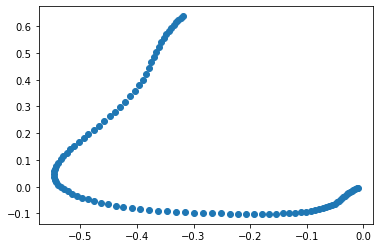

[47] loss: 0.003


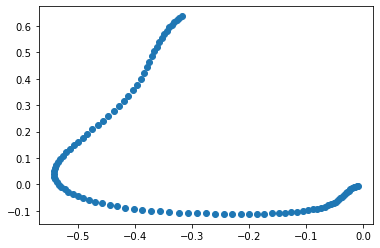

[48] loss: 0.002


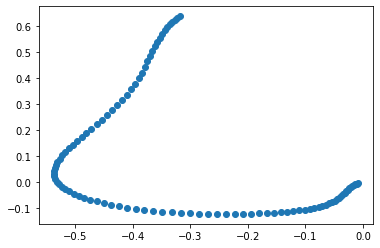

[49] loss: 0.002


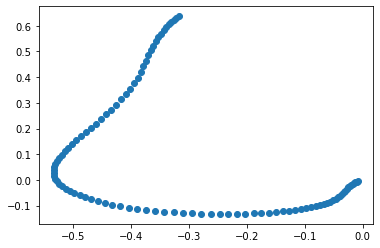

[50] loss: 0.002


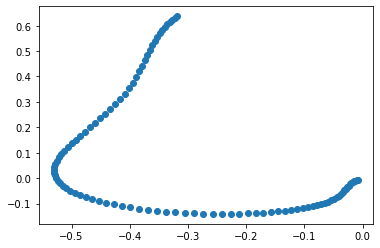

[51] loss: 0.002


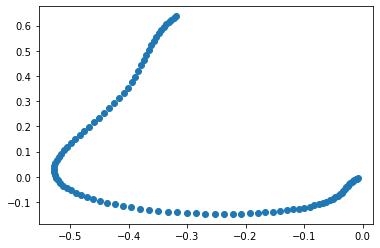

[52] loss: 0.002


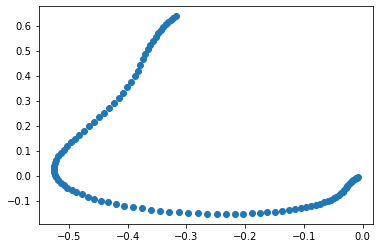

[53] loss: 0.002


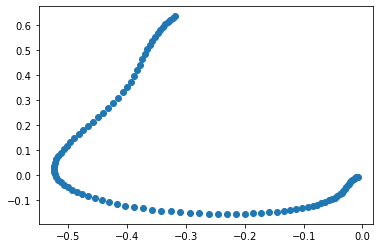

[54] loss: 0.002


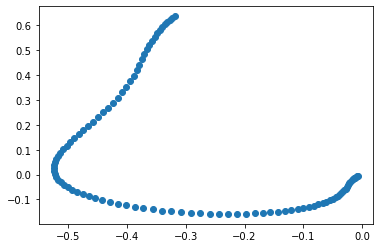

[55] loss: 0.001


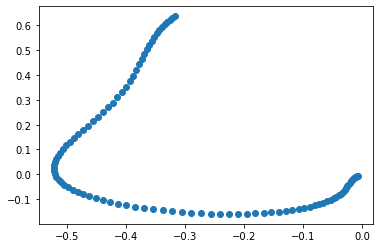

[56] loss: 0.001


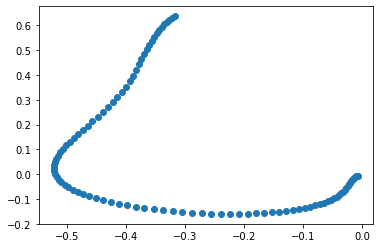

[57] loss: 0.001


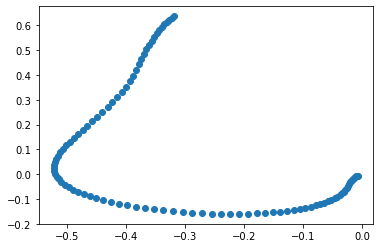

[58] loss: 0.001


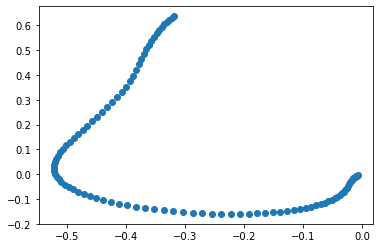

[59] loss: 0.001


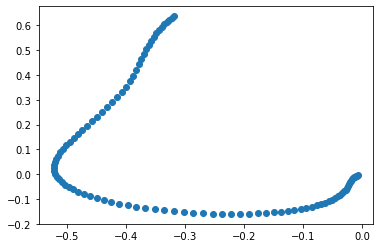

[60] loss: 0.001


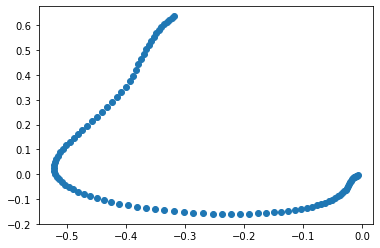

[61] loss: 0.001


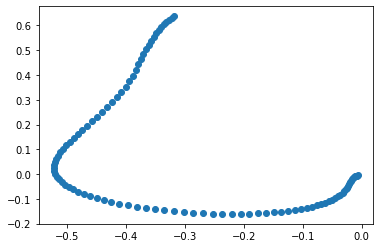

[62] loss: 0.001


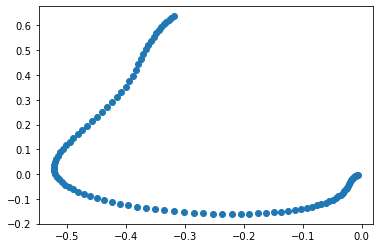

[63] loss: 0.001


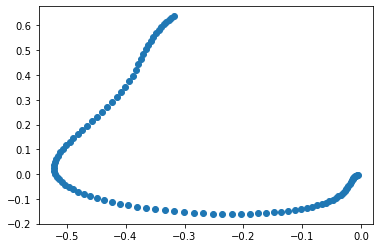

[64] loss: 0.001


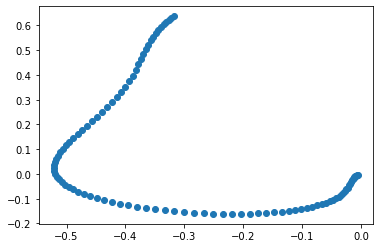

[65] loss: 0.001


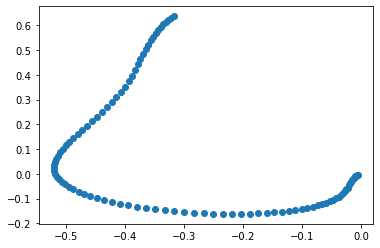

[66] loss: 0.001


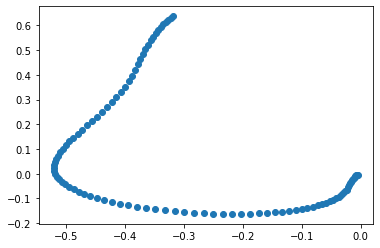

[67] loss: 0.001


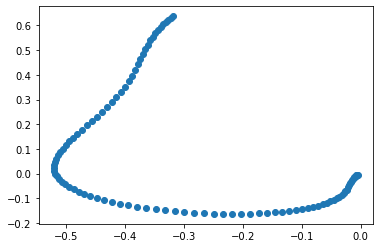

[68] loss: 0.001


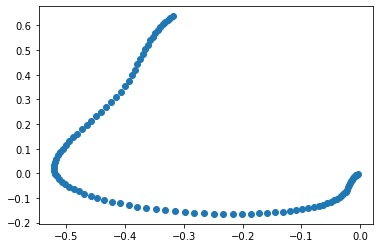

[69] loss: 0.001


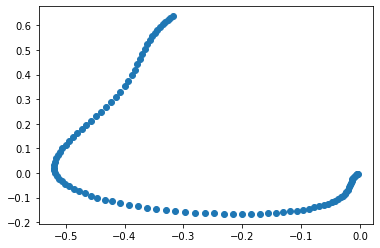

[70] loss: 0.001


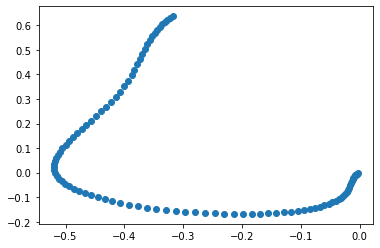

[71] loss: 0.001


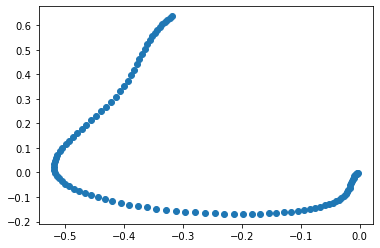

[72] loss: 0.001


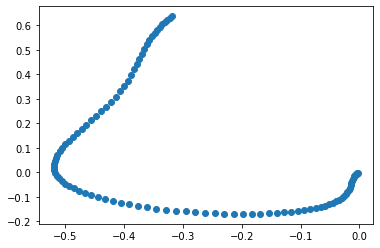

[73] loss: 0.001


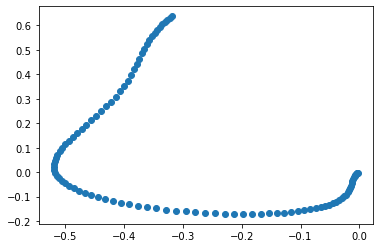

[74] loss: 0.000


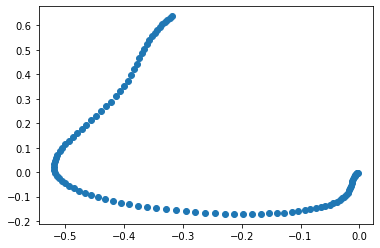

[75] loss: 0.000


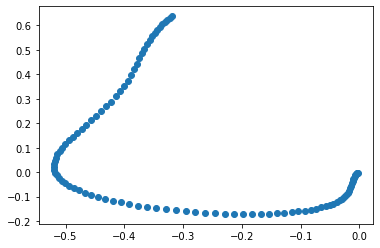

[76] loss: 0.000


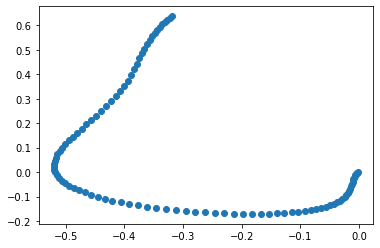

[77] loss: 0.000


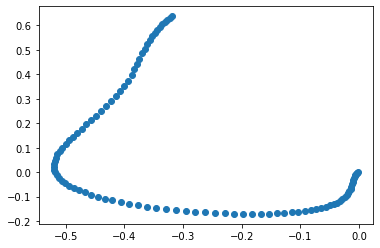

[78] loss: 0.000


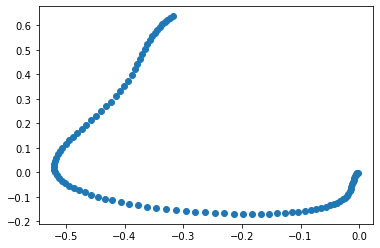

[79] loss: 0.000


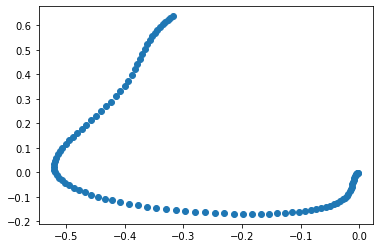

[80] loss: 0.000


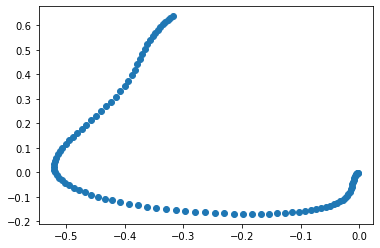

Landing Trajectory:


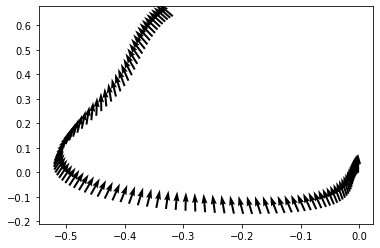

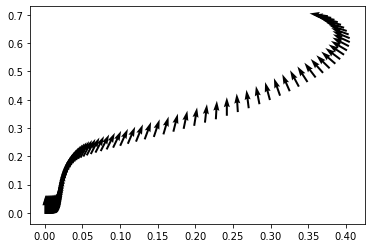

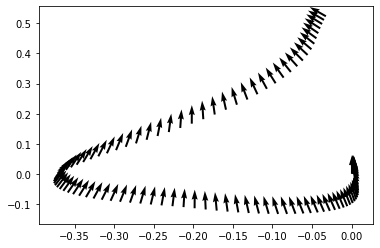

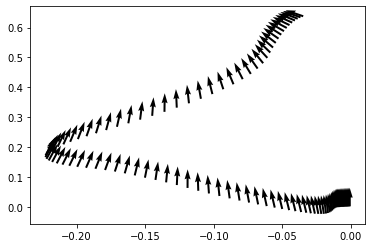

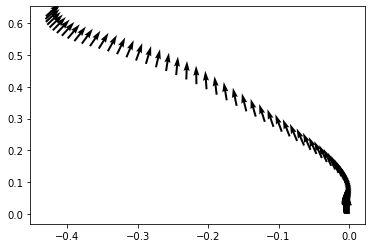

Convergence Plot:


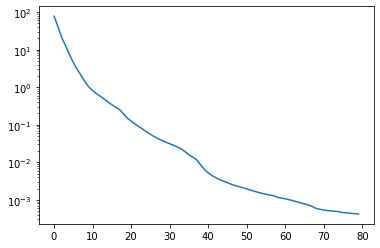

In [296]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 5
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(80)  # solve the optimization problem
